# Лабораторная работа №1

## Реализация алгоритма обратного распространения ошибки

### Содержание

[Активационные функции](#Активационные-функции)
   
- [Линейная функция](#Линейная-функция)
- [Сигмоида](#sigmoida)
- [ReLU](#ReLU)
  
[Слои нейросетей](#Слои-нейросетей)

- [Полносвязный слой](#Полносвязный-слой)

[Конструктор нейросети](#Конструктор-нейросети)
- [Пример обучения](#Пример-обучения)
- [Задача XOR](#Задача-XOR)
- [Создание нейросети](#Создание-нейросети)
- [Обучение нейросети](#Обучение-нейросети)
- [Вывод](#%D0%92%D1%8B%D0%B2%D0%BE%D0%B4)

In [31]:
# Подключение библиотек
import numpy as np
from abc import ABC, abstractclassmethod

## Активационные функции

In [32]:
# Объединение вещественных чисел и массивов NumPy. 
# Nbg для описания функций, которые принимают как скаляры, так и массивы.
ArrayLike = float | np.ndarray

class Active(ABC):    
    """
    Абстрактный базовый класс функций активации.

    Наследники должны реализовать статические методы __call__ и dx,
    вычисляющие значение функции и её производную для входных данных.
    """
    
    @staticmethod
    @abstractclassmethod
    def __call__(x: ArrayLike) -> ArrayLike:
        """
        Вычислить активацию.

        Аргументы:
            x: входные данные (число или массив).
        
        Возвращает:
            Значение функции активации.
        """
        pass
        
    @staticmethod
    @abstractclassmethod
    def dx(x: ArrayLike) -> ArrayLike:
        """
        Вычислить производную функции активации.

        Аргументы:
            x: значения функции активации (не исходные данные).
        
        Возвращает:
            Производная функции активации.
        """
        pass

### Линейная функция

    Линейная функция активации возвращает входное значение без изменений.
    Используется в задачах регрессии на выходном слое, либо для простых моделей.
    Производная функции постоянна и равна 1.
    
    Ограничение: если все слои нейросети используют линейные функции активации, 
    итоговая сеть будет линейной и не сможет обучаться сложным нелинейным закономерностям.



In [705]:
class Liner(Active):
    
    @staticmethod
    def __call__(x: ArrayLike) -> ArrayLike:
        """
        Линейная функция активации.

        Аргументы:
            x: Входные данные, скаляр или массив.

        Возвращает:
            То же значение, что и вход, без изменений.
        """
        return x

    @staticmethod
    def dx(x: ArrayLike) -> ArrayLike:
        """
        Производная линейной функции активации.

        Аргументы:
            x: Не влияет на результат, передаётся для соответствия интерфейсу.

        Возвращает:
            Постоянное значение 1 того же типа, что и x.
        """
        if isinstance(x, np.ndarray):
            return np.ones_like(x)
        else:
            return 1.0


### Cигмоида <a id="sigmoida"></a>

        Сигмоидная функция — это S-образная (сигмоидальная) функция, 
        которая преобразует любое входное вещественное число в значение 
        в диапазоне от 0 до 1. Этот диапазон удобно интерпретировать как 
        вероятность, поэтому sigmoid часто используется в выходных слоях 
        нейронных сетей, решающих задачи бинарной классификации.
        
        Применение сигмоиды распространено в машинном обучении и глубоком обучении 
        именно для преобразования линейных комбинаций входных данных и весов нейрона 
        в нелинейные выходы. Это позволяет моделям обучаться сложным закономерностям,
        делая их более выразительными, чем простые линейные функции.
            
        Диапазон значений функции сигмоида: (0, 1). Значение близкое к 0 
        соответствует сильному отрицательному входу, значение близкое к 1 — сильному 
        положительному входу, а при входе 0 выход ровно 0.5.
        
        Однако сигмоида имеет и некоторые ограничения, например, проблему затухающего
        градиента (из-за производной), что может замедлять обучение глубоких моделей.

        Производная сигмоиды важна для обучения нейронных сетей методом
        обратного распространения ошибки, так как она используется для
        расчёта градиентов, необходимых для обновления весов.

        Производная вычисляется по формуле:
            sigmoid'(x) = x * (1 - x),
        где x — значение функции сигмоида в данной точке.

        Наибольшее значение производной (0.25) достигается при входе,
        соответствующем выходу 0.5 (точка перегиба), а для значений близких к 0 или 1
        (насыщение функции) производная стремится к нулю, что ведёт к проблеме
        затухающего градиента и замедляет обучение глубоких сетей.

In [34]:
class Sigmoid(Active):
    
    @staticmethod
    def __call__(x: ArrayLike) -> ArrayLike:
        """
        Активационная функция - сигмоида.
        
        Аргументы:
            x: Входные данные, могут быть числами или массивами.
    
        Возвращает:
            Значения функции, лежащие в диапазоне от 0 до 1.
            
        Пример:
            >>> import numpy as np
            >>> sigmoid(np.array([-2, 0, 2]))
            array([0.11920292, 0.5, 0.88079708])
        """
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def dx(x: ArrayLike) -> ArrayLike:
        """
        Производная сигмоидной функции.
    
        Аргументы:
            x: Значения функции сигмоиды (не исходные аргументы),
               для которых вычисляется производная.
    
        Возвращает:
            Производные значения сигмоидной функции, численно выражающие
            скорость изменения функции активации в данной точке. Диапазон 
            производной лежит в интервале (0, 0.25).
    
        Пример:
            >>> import numpy as np
            >>> s = 1 / (1 + np.exp(-np.array([-2., 0., 2.])))
            >>> Sigmoid.dx(s)
            array([0.10499359, 0.25      , 0.10499359])
        """
        return x * (1 - x)           

### ReLU
    ReLU возвращает 0 для всех отрицательных значений входа и
    входное значение без изменений для неотрицательных. 
    Это простая и эффективная функция, широко используемая 
    для устранения проблемы затухающего градиента в глубоких сетях.

In [35]:
class ReLU(Active):

    @staticmethod
    def __call__(x: ArrayLike) -> ArrayLike:
        """
        Функция активации ReLU (Rectified Linear Unit).

        Аргументы:
            x: Входные данные, скаляр или массив.

        Возвращает:
            Значения, где отрицательные элементы заменены на 0, 
            положительные остались без изменений.
        """
        return np.maximum(0, x)

    @staticmethod
    def dx(x: ArrayLike) -> ArrayLike:
        """
        Производная функции ReLU.

        Аргументы:
            x: Входные данные (реальное значение функции активации)
        Возвращает:
            1 для положительных элементов x, 0 для отрицательных и нуля.
        """
        return np.where(x > 0, 1, 0)


## Слои нейросетей

In [529]:
# Абсрактный класс слоя нейросети

from abc import ABC, abstractmethod

class Layer(ABC):
    """
    Абстрактный базовый класс слоя нейронной сети.

    Этот класс задаёт общий интерфейс для всех конкретных реализаций слоёв нейронной сети.
    Его нельзя инстанцировать напрямую — необходимо создавать подклассы и реализовывать
    все абстрактные методы.

    Использование:
        Наследовать этот класс в конкретном слое (например, Dense, Convolutional и т.д.) и
        полностью реализовать методы forward и backward, соответствующие специфике слоя.
    """
    @abstractmethod
    def __init__(self, input_shape:tuple[int], active: Active | None= None):
        pass
    
    def connect(self, next_layer: Layer):
        """
        Присоединение к следующему слою.
        Запуск инициализации весов.
        """
        self.output_shape = next_layer.input_shape
        self.init_weights()
        
    @abstractmethod
    def init_weights(self):
        """
        Алгоритм инициализации весов модели.
        """
        pass
        
    @abstractmethod
    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Прямое распространение данных через слой.
        Выполняет прямое распространение входных данных через слой.
        Принимает входной тензор и возвращает выход слоя — тот же или преобразованный тензор.
        
        Аргументы:
            X: Входной массив данных, который нужно пропустить через слой.

        Возвращает:
            Результат прохождения данных через слой.
        """
        pass

    @abstractmethod
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Обратное распространение ошибки через слой.
        Выполняет обратное распространение ошибки через слой.
        Принимает градиенты ошибки, полученные от следующего слоя, и рассчитывает
        локальные градиенты для текущего слоя.
        Обновляет внутренние параметры слоя (например, веса) на основе этих градиентов.
        
        Аргументы:
            gradient: Градиенты ошибки, поступающие от следующего слоя.

        Возвращает:
            Градиенты ошибки относительно входов текущего слоя,
            используемые для передачи в предыдущий слой.
        """
        pass
    

### Полносвязный слой

In [708]:
class Dense(Layer):
    """
    Полносвязный (Dense) слой нейронной сети.

    Атрибуты:
        input_shape (tuple[int]): Размерность входного вектора (число признаков).
        output_shape (tuple[int]): Размерность выходного вектора (число нейронов).
        weights (np.ndarray | None): Матрица весов размера (input_features, output_features).
        bias (np.ndarray | None): Вектор смещений размера (1, output_features).
        output (np.ndarray | None): Выход слоя после активации.
        input (np.ndarray | None): Входной массив, сохранённый для обратного прохода.
        delta (np.ndarray | None): Ошибка слоя для обратного распространения.
        active (Active): Функция активации.
    """

    def __init__(self, input_shape: tuple[int], active: Active | None = None, *, output_shape: tuple[int] | None = None):
        """
        Инициализация слоя Dense.

        Аргументы:
            input_shape: Размерность входных данных.
            active: Функция активации, по умолчанию линейная.
            output_shape: Размерность выходных данных. 
                          Если задана, происходит инициализация весов.
        """
        self.input_shape = input_shape
        self.weights = None
        self.bias = None
        self.output = None
        self.input = None
        self.delta = None
        self.active = active or Liner()
        if output_shape is not None:
            self.output_shape = output_shape
            self.init_weights()

    def init_weights(self):
        """
        Инициализация весов и смещений.

        Веса инициализируются случайными значениями из нормального распределения,
        масштабированными на 0.05. Смещения инициализируются нулями.
        """
        self.weights = np.random.randn(self.input_shape[0], self.output_shape[0]) * 0.05
        self.bias = np.zeros((1, self.output_shape[0]))

    def forward(self, X: np.ndarray):
        """
        Прямой проход слоя.

        Вычисляет линейное преобразование входа с весами и смещением,
        затем применяет функцию активации.

        Аргументы:
            X: Входной массив размерности (batch_size, input_features).

        Возвращает:
            Выход слоя после активации размерности (batch_size, output_features).
        """
        self.input = X
        z = X @ self.weights
        self.output = self.active(z + self.bias)
        return self.output

    def backward(self, output_error, learning_rate):
        """
        Обратное распространение ошибки и обновление параметров слоя.
    
        Вычисляет локальную ошибку слоя с учётом производной функции активации,
        затем применяет метод стохастического градиентного спуска (SGD) для 
        обновления весов и смещений.
    
        Обновление весов и смещений происходит по формуле:
            параметр := параметр + learning_rate * градиент

        Аргументы:
            output_error: Ошибка, поступающая от следующего слоя
                          размерности (batch_size, output_features).
            learning_rate: Темп обучения.

        Возвращает:
            Ошибка для передачи предыдущему слою (batch_size, input_features).
        """
        delta = output_error * self.active.dx(self.output)
        self.delta = delta
        weights_error = np.dot(self.input.T, delta)
        self.weights += learning_rate * weights_error
        self.bias += learning_rate * np.sum(delta, axis=0, keepdims=True)
        input_error = np.dot(delta, self.weights.T)
        return input_error


## Конструктор нейросети

In [709]:
class NeuralNetwork:
    """
    Класс простой нейронной сети с последовательным размещением слоев.
    """

    def __init__(self, layers: list[Layer] | None = None):
        """
        Инициализация нейросети.

        Если передан список слоёв, они добавляются в сеть.

        Аргументы:
            layers: Список слоёв для нейросети (опционально).
        """
        self.layers: list[Layer] = []
        if layers is not None:
            for layer in layers:
                self.add(layer)

    def add(self, layer: Layer):
        """
        Добавляет новый слой в конец сети.

        Если последний слой ещё не инициализирован (например, веса None),
        устанавливает связь с новым слоем.

        Аргументы:
            layer: Слой для добавления.
        """
        if len(self.layers):
            if self.layers[-1].weights is None:
                self.layers[-1].connect(layer)
        self.layers.append(layer)

    def forward(self, X: np.ndarray):
        """
        Прямое вычисление выходных данных сети для входных данных X.

        Аргументы:
            X: Входные данные для сети, форма (batch_size, features).

        Возвращает:
            Выход сети после прохода по всем слоям.
        """
        assert len(self.layers)
        output = self.layers[0].forward(X)
        for layer in self.layers[1:]:
            output = layer.forward(output)
        return output

    def backward(self, X: np.ndarray, y: np.ndarray, learning_rate: float):
        """
        Обратное распространение ошибки и обновление весов сети.

        Производится прямой проход для получения выхода,
        вычисляется ошибка, затем ошибки проходят по слоям в обратном порядке
        для корректировки весов с использованием learning_rate.

        Аргументы:
            X: Входные данные, форма (batch_size, features).
            y: Целевые значения (метки), форма (batch_size, output_features).
            learning_rate: Темп обучения для обновления весов.
        """
        output_out = self.forward(X)
        output_error = y - output_out
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error, learning_rate)

    def train(self, X: np.ndarray, y: np.ndarray, learning_rate: float, epochs: int):
        """
        Тренировка нейросети методом обратного распространения с указанным числом эпох.

        Аргументы:
            X: Обучающие входные данные.
            y: Обучающие метки.
            learning_rate: Скорость обучения.
            epochs : Количество итераций обучения (эпох).
        """
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)


## Пример обучения

### Задача XOR

    Задача XOR — классическая проблема в развитии искусственных нейронных сетей, которая
    заключается в том, что однослойный персептрон не может корректно классифицировать входные 
    данные для функции "исключающее ИЛИ" (XOR), так как набор данных не является линейно разделимым.

    Эта неспособность стала причиной первой "зимы ИИ" — периода снижения интереса и финансирования
    исследований в области искусственного интеллекта, продолжавшегося примерно с середины 1960-х до начала 1980-х годов.

    Решение проблемы было найдено в 1986 году с разработкой алгоритма обратного распространения 
    ошибки (Backpropagation) и внедрением многослойных перцептронов, которые смогли успешно решать 
    негладко разделимые задачи, включая XOR, благодаря наличию скрытых слоёв.

In [710]:
# Датасет XOR
# Входные данные (4 образца, 2 признака)
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
# Метки (целевые значения)
y = np.array([0, 1, 1, 0])
X.shape, y.shape

((4, 2), (4,))

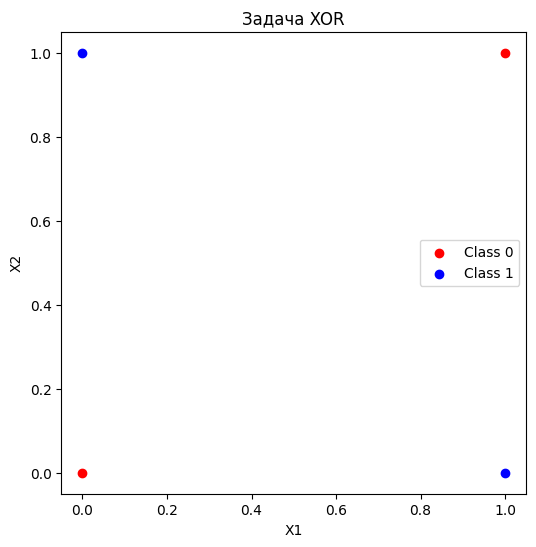

In [711]:
# Визуализация данных XOR
plt.figure(figsize=(6,6))
for cls, color in zip([0, 1], ['red', 'blue']):
    plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f'Class {cls}')
plt.title("Задача XOR")
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
pass

### Создание нейросети

In [712]:
## Создание многослойной (2-х слойной) полносвязной нейронной сети
np.random.seed(42)
model = NeuralNetwork([
    Dense(input_shape=(2,), active=ReLU()),
    Dense(input_shape=(2,), active=ReLU()),
    Dense(input_shape=(3,), active=Sigmoid(), output_shape=(1,))
])

In [713]:
model.forward(X)

array([[0.5       ],
       [0.50000773],
       [0.50003487],
       [0.50002642]])

In [714]:
# Данные для отображения
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
x1, x2 = np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200)
x1.shape, x2.shape

((200,), (200,))

In [715]:
data_x = np.column_stack((x1, x2))
data_x.shape

(200, 2)

In [716]:
predict = model.forward(data_x)
predict[:5], predict.shape

(array([[0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5]]),
 (200, 1))

In [717]:
xx, yy = np.meshgrid(x1, x2)
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape

(40000, 2)

In [718]:
# предсказания модели по этим точкам (размер (40000, 1))
predict = model.forward(grid)
predict.shape

(40000, 1)

In [719]:
# (40000, 1) -> (200, 200)
predict = predict.reshape(200, 200)
predict.shape

(200, 200)

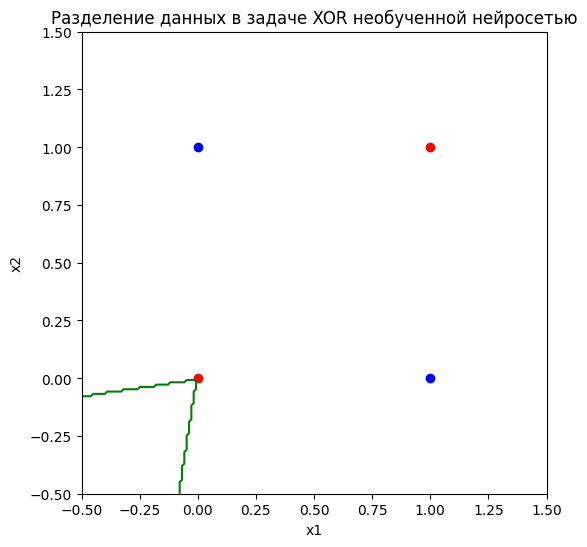

In [720]:
plt.figure(figsize=(6,6))
plt.contour(xx, yy, predict, levels=[0.5], colors='green')
for cls, color in zip([0, 1], ['red', 'blue']):
    plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f'Class {cls}')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Разделение данных в задаче XOR необученной нейросетью')
plt.show()


### Обучение нейросети

In [721]:
model.train(X, y.reshape(4,1), learning_rate=0.5, epochs=10000)

for x_sample in X:
    output = model.forward(x_sample)
    print(f"Input: {x_sample} Output: {output}")

Input: [0 0] Output: [[0.00762283]]
Input: [0 1] Output: [[0.99812529]]
Input: [1 0] Output: [[0.99830754]]
Input: [1 1] Output: [[0.00762283]]


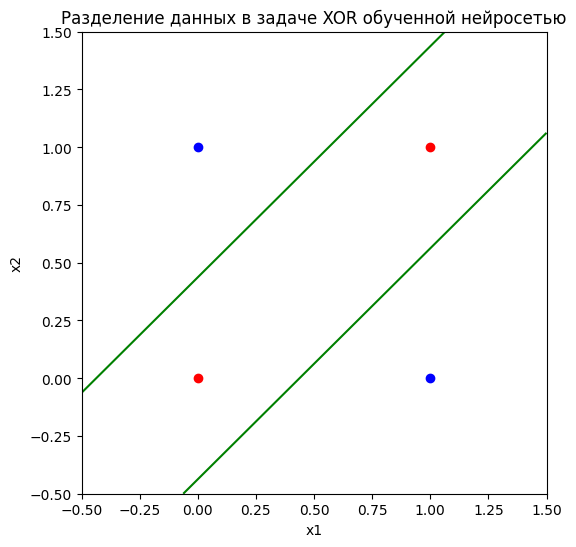

In [722]:
predict = model.forward(grid)

plt.figure(figsize=(6,6))
plt.contour(xx, yy, predict.reshape(200, 200), levels=[0.5], colors='green')
for cls, color in zip([0, 1], ['red', 'blue']):
    plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f'Class {cls}')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Разделение данных в задаче XOR обученной нейросетью')
plt.show()


## Вывод

    В ходе работы был изучен и реализован метод обратного распространения ошибки 
    для обучения нейронных сетей. В частности, реализован простой стохастический 
    градиентный спуск (SGD), а также базовые классы полносвязного слоя (Dense) и 
    функций активации — сигмоидальной (Sigmoid) и ReLU.

    Работоспособность модели успешно продемонстрирована на классической задаче XOR.

